In [1]:
from typing import Optional

from data import CLEVRDataModule
from method import SlotAttentionMethod
from model import SlotAttentionModel
from params import SlotAttentionParams
from utils import ImageLogCallback
from utils import rescale
from utils import to_rgb_from_tensor
from utils import sample_images_inference
from torchvision import utils as vutils
from torchvision import transforms
import os
import torch
import matplotlib.image as img
import numpy as np


In [2]:
import matplotlib.pyplot as plt

In [3]:
params = SlotAttentionParams()

assert params.num_slots > 1, "Must have at least 2 slots."

clevr_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(rescale),  # rescale between -1 and 1
        transforms.Resize(params.resolution),
    ]
)

clevr_datamodule = CLEVRDataModule(
    data_root=params.data_root,
    max_n_objects=params.num_slots - 1,
    train_batch_size=params.batch_size,
    val_batch_size=params.val_batch_size,
    clevr_transforms=clevr_transforms,
    num_train_images=params.num_train_images,
    num_val_images=params.num_val_images,
    num_workers=params.num_workers,
)

model = SlotAttentionModel(
    resolution=params.resolution,
    num_slots=params.num_slots,
    num_iterations=params.num_iterations,
    empty_cache=params.empty_cache,
)

checkpoint = torch.load("/kuacc/users/ashah20/video_dataset_working/new_original/slot-attention-clevr6/2eokusdj/checkpoints/epoch=142-step=44758.ckpt")
checkpoint['state_dict'] = dict([(key.replace("model.", ""), value) for key, value in checkpoint['state_dict'].items()])
model.load_state_dict(checkpoint['state_dict'])

model.cuda()
model.eval()

save_path = str(params.output_images_inferece)


In [27]:

images, attns = sample_images_inference(model, clevr_datamodule, params)
images = images.detach().cpu().numpy().transpose(1,2,0)

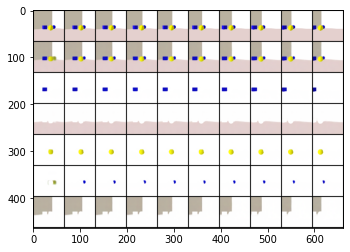

In [28]:
plt.imshow(images)

In [29]:
nFrames = 10
W, H = params.resolution

attns1_grid = np.zeros((W*params.num_slots,H*nFrames,1))
attns2_grid = np.zeros((15,5*nFrames,1))
attnm_grid = np.zeros((15,5*nFrames,1))

In [30]:
for j in range(nFrames):

    attns1, attns2, attnm = attns[j]

    attns1_new = [attns1[:,:,i].view(1,*params.resolution).cpu().detach().numpy().transpose(1,2,0) for i in range(attns1.shape[-1])]

    #a = attns1_new[0]
    #a = np.concatenate([a,a,a], axis = 2)
    #a.shape
    attns2_grid[:,5*j:5*(j+1),:] = attns2.cpu().detach().numpy().transpose(1,2,0) 
    attnm_grid[:,5*j:5*(j+1),:] = attnm.cpu().detach().numpy().transpose(1,2,0) 

    for i in range(params.num_slots):
        attns1_grid[i*W:(i+1)*W,j*H:(j+1)*H,:] = attns1_new[i]

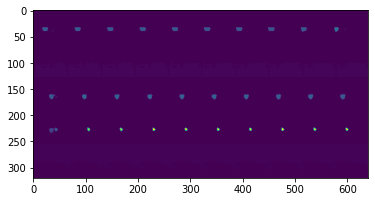

In [31]:
plt.imshow(attns1_grid)

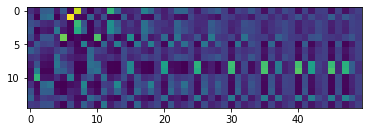

In [32]:
#
plt.imshow(attns2_grid)

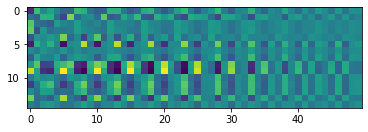

In [33]:
# left to right: frame 1 to frame 10
plt.imshow(attnm_grid)